In [1]:
# Importing Libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler

In [2]:
team = pd.read_excel('final_team_master_data.xlsx')
stats = pd.read_excel('team_stats.xlsx')

In [3]:
stats.shape

(1120, 6)

In [4]:
team.shape

(80, 31)

In [5]:
all_out_inflict = stats[stats['Points'] == 'all-outs-inflicted']

In [6]:
all_out_inflict.shape

(80, 6)

In [7]:
all_out_conceded = stats[stats['Points'] == 'all-outs-conceded']

In [8]:
all_out_conceded.shape

(80, 6)

In [9]:
all_out_inflict.sort_values(by=['Name','Season'],inplace=True)

In [10]:
all_out_conceded.sort_values(by=['Name','Season'],inplace=True)

In [11]:
team.sort_values(by=['Team','Season'],inplace=True)

In [12]:
all_out_inflict.index = range(0,len(all_out_inflict))
all_out_conceded.index = range(0,len(all_out_conceded))
team.index = range(0,len(team))

In [13]:
team['Season'] = team['Season'].replace('Overall','All Season')

In [14]:
inflict = []
for each in all_out_inflict.columns:
    inflict.append('inflict-'+each)
    
all_out_inflict.columns = inflict

In [15]:
conceded = []
for each in all_out_conceded.columns:
    conceded.append('conceded-'+each)
    
all_out_conceded.columns = conceded

In [16]:
df = pd.concat([all_out_inflict,all_out_conceded,team],sort=False,axis=1)

In [17]:
df.shape

(80, 43)

In [18]:
df['super-performance'] = df['no. of super raids'] + df['no. of super tackles'] + df['inflict-Total Points'] - df['conceded-Total Points']

In [19]:
team_name = df['Team']

In [20]:
df.drop(['Team','inflict-Name','conceded-Name','conceded-Season','inflict-Season','inflict-Points',
'conceded-Points','no. of super raids','no. of super tackles','inflict-Total Points',
         'conceded-Total Points','conceded-Matches Played','Highest Score_Team opposition',
        'Biggest Winning Margin_Team1','Biggest Winning Margin_Team2','all outs inflicted',
        'unsuccesful tackles','successful tackles'],axis=1,inplace=True)

In [21]:
df['success raid %'] = df['success raid %'].apply(lambda x : int(x[:-1]))

In [22]:
df['successful tackle %'] = df['successful tackle %'].apply(lambda x : int(x[:-1]))

In [23]:
df['Finishing Position'] = df['Finishing Position'].str.replace('-','0')
df['Finishing Position'] = df['Finishing Position'].astype('int')

In [24]:
df.shape

(80, 26)

In [25]:
# Creating train and test. We will test the model on Season 7 data

train=df[df['Season']!='Season 7']

test=df[df['Season']=='Season 7']

# Dropping Season column as it is no more required. The test and train data has been split basis the season
y_train=train['super-performance']
train=train.drop(['Season','super-performance'], axis=1)


y_test=test['super-performance']
test=test.drop(['Season','super-performance'], axis=1)

print("Train Data Shape is: ", train.shape)
print("Test Data Shape is: ", test.shape)

Train Data Shape is:  (68, 24)
Test Data Shape is:  (12, 24)


In [26]:
print('Train Shape is', train.shape)
print('y_train Shape is', y_train.shape)

Train Shape is (68, 24)
y_train Shape is (68,)


In [27]:
print('Test Shape is', test.shape)
print('y_test Shape is', y_test.shape)

Test Shape is (12, 24)
y_test Shape is (12,)


In [28]:
# Scaling the features
# storing the columns in a variable for avoiding them from lossing after scaling
X_train_cols=train.columns

scaler=StandardScaler()
train[X_train_cols]=scaler.fit_transform(train[X_train_cols])

train.head()

,inflict-Rank,inflict-Matches Played,conceded-Rank,Matches Played,Wins,Draws,Losses,Finishing Position,Highest Score,Biggest Winning Margin,...,unsuccessful raid,empty raids,success raid %,raid touch points,raid bonus points,total raid points,total tackles,successful tackle %,total all out points,total defence points
0,0.810263,2.562144,0.177663,2.580274,2.341810,3.240593,2.401163,-1.358687,0.128452,1.202559,...,2.449546,2.661770,-0.016508,2.476751,2.539493,2.498002,2.520829,-0.310699,2.086597,2.313941
1,0.810263,-0.559165,-1.094031,-0.560119,-0.668456,-0.615713,-0.376742,1.502973,-0.609696,-1.698020,...,-0.523829,-0.681408,1.587110,-0.513317,-0.490463,-0.509969,-0.485664,-1.806452,-0.664640,-0.590416
2,0.810263,-0.559165,-0.458184,-0.560119,-0.668456,-0.615713,-0.376742,1.094164,-0.978771,-1.921142,...,-0.508797,-0.491121,-1.780487,-0.652063,-0.710025,-0.666618,-0.579499,0.437178,-0.688155,-0.548925
3,-0.478576,-0.502414,-0.458184,-0.502497,-0.367429,-0.891163,-0.500205,0.276547,-1.224820,-0.359291,...,-0.529842,-0.436974,-0.978678,-0.545490,-0.614881,-0.562185,-0.550723,0.811116,-0.523551,-0.507434
4,0.488053,-0.559165,-0.140260,-0.560119,-0.728661,-0.340262,-0.376742,1.911781,-1.593895,-1.363338,...,-0.586964,-0.491121,-1.299402,-0.646031,-0.600244,-0.638136,-0.564486,-0.497668,-0.664640,-0.581525


In [29]:
# Scaling the test data
test[X_train_cols]=scaler.transform(test[X_train_cols])
test.head()

,inflict-Rank,inflict-Matches Played,conceded-Rank,Matches Played,Wins,Draws,Losses,Finishing Position,Highest Score,Biggest Winning Margin,...,unsuccessful raid,empty raids,success raid %,raid touch points,raid bonus points,total raid points,total tackles,successful tackle %,total all out points,total defence points
7,-1.122996,-0.417287,1.767282,-0.444875,-0.247019,-0.064812,-0.685398,-0.541070,0.128452,1.202559,...,-0.526835,-0.511232,1.266386,-0.344410,-0.439232,-0.365979,-0.435618,0.063240,-0.241373,-0.430380
15,0.165843,-0.417287,-0.776108,-0.444875,-0.367429,-0.615713,-0.438473,0.276547,0.005428,0.086952,...,-0.346449,-0.580850,1.266386,-0.394680,-0.256263,-0.365979,-0.445627,0.437178,-0.476521,-0.415562
23,-1.445206,-0.417287,2.085205,-0.473686,-0.126608,-0.340262,-0.808861,-0.949879,0.374502,-0.024609,...,-0.553893,-0.570020,1.426748,-0.426853,-0.322132,-0.405537,-0.473152,-0.123730,-0.264888,-0.477798
27,0.165843,-0.388912,0.177663,-0.444875,-0.608251,-0.340262,-0.253280,2.320590,-0.363647,0.533195,...,-0.361481,-0.498856,-0.657955,-0.523371,-0.512419,-0.522628,-0.509435,1.185055,-0.523551,-0.436307
31,-0.478576,-0.417287,1.131434,-0.473686,-0.247019,-0.615713,-0.623667,-0.132262,0.005428,0.198512,...,-0.508797,-0.514326,0.945663,-0.408756,-0.483144,-0.426107,-0.424358,-0.123730,-0.335432,-0.430380


In [30]:
# Defining alphas for identiying the optimum alphas for Lasso regression
params = {'alpha': [0.00000000001, 0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001,0.01,0.02,0.05,0.1,0.2,0.3,0.4,0.5,
                    0.6,0.7,0.8,0.9,1,10,100,500,1000,200]}

# Lasso Modelling
lasso = Lasso()

# cross validation
folds=5
lasso_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

lasso_cv.fit(train, y_train) 

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.4s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [1e-11, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001,
                                   0.001, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4,
                                   0.5, 0.6, 0.7, 0.8, 0.9, 1, 10, 100, 500,
                                   1000, 200]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [31]:
# Printing the model output

lasso_cv_results = pd.DataFrame(lasso_cv.cv_results_)
lasso_cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.009754,0.009750,0.000796,0.001159,1e-11,{'alpha': 1e-11},-11.525575,-10.823069,-12.994733,-8.238150,...,-10.256781,2.081946,20,-5.468443,-5.301675,-4.672072,-5.126681,-5.503098,-5.214394,0.302429
1,0.003124,0.006249,0.000000,0.000000,1e-08,{'alpha': 1e-08},-11.525575,-10.823068,-12.994733,-8.238150,...,-10.256781,2.081946,19,-5.468443,-5.301675,-4.672072,-5.126681,-5.503098,-5.214394,0.302429
2,0.003797,0.006193,0.000200,0.000400,1e-07,{'alpha': 1e-07},-11.525572,-10.823065,-12.994727,-8.238149,...,-10.256779,2.081943,18,-5.468442,-5.301675,-4.672072,-5.126681,-5.503098,-5.214394,0.302428
3,0.002791,0.000399,0.000599,0.000489,1e-06,{'alpha': 1e-06},-11.525544,-10.823034,-12.994666,-8.238146,...,-10.256757,2.081917,17,-5.468434,-5.301677,-4.672071,-5.126684,-5.503093,-5.214392,0.302426
4,0.003568,0.006102,0.000000,0.000000,1e-05,{'alpha': 1e-05},-11.525262,-10.822720,-12.994062,-8.238110,...,-10.256538,2.081658,16,-5.468355,-5.301699,-4.672065,-5.126705,-5.503051,-5.214375,0.302408


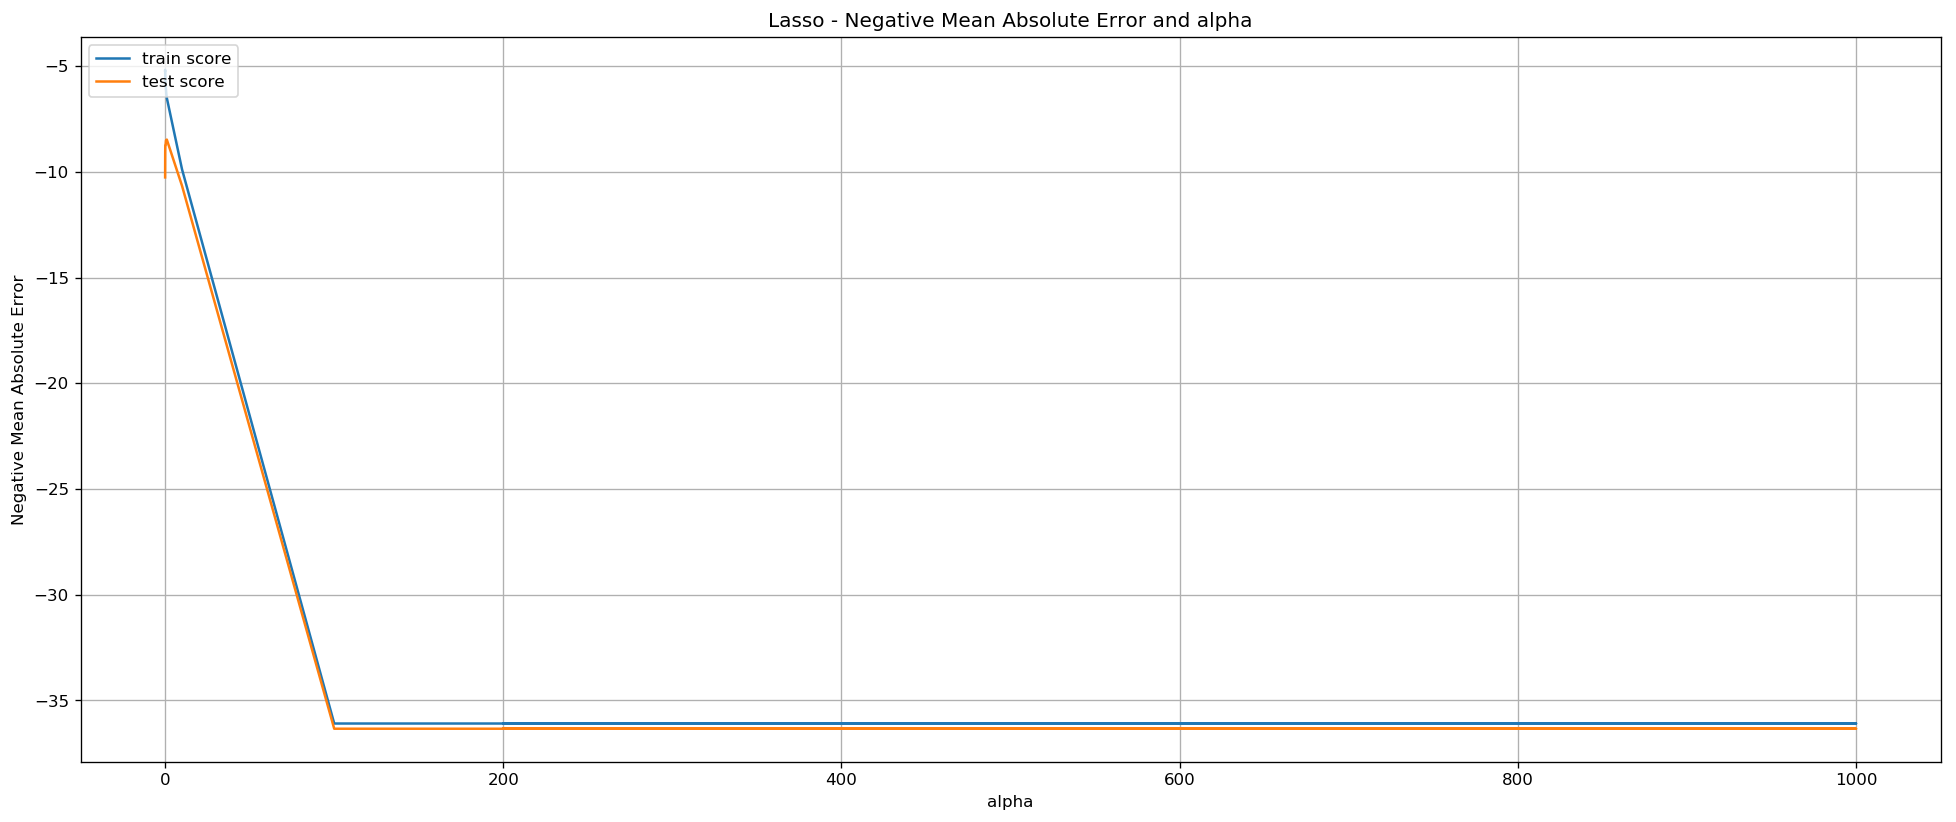

In [32]:
# plotting mean test and train scoes with alpha 
lasso_cv_results['param_alpha'] = lasso_cv_results['param_alpha'].astype('float32')

# plotting
plt.figure(num=None, figsize=(20, 8), dpi=120, facecolor='w', edgecolor='k')
plt.plot(lasso_cv_results['param_alpha'], lasso_cv_results['mean_train_score'])
plt.plot(lasso_cv_results['param_alpha'], lasso_cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')

plt.title("Lasso - Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.grid()
plt.show()

In [33]:
print(lasso_cv.best_params_['alpha'])

1


In [34]:
alpha = lasso_cv.best_params_['alpha']
lasso = Lasso(alpha=alpha)
lasso.fit(train, y_train) 

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

In [35]:
lasso.score(train, y_train)

0.9665842111657369

In [36]:
lasso.score(test, y_test)

0.6547501173356074

In [37]:
y_test_pred=lasso.predict(test)
print(r2_score(y_test,y_test_pred))
print(np.sqrt(mean_squared_error(y_test,y_test_pred)))

0.6547501173356074
6.746513385785956


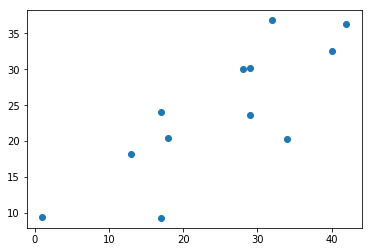

In [38]:
plt.scatter(y_test,y_test_pred)

In [39]:
features = np.abs(pd.Series(dict(zip(train.columns,lasso.coef_)))).sort_values(ascending=False)
print(features)

total all out points                  39.116912
Wins                                   9.043711
Highest Score                          2.788087
Draws                                  1.836142
successful tackle %                    1.767160
inflict-Rank                           1.293838
Biggest Winning Margin_Team1_Score     0.023063
inflict-Matches Played                 0.000000
conceded-Rank                          0.000000
Matches Played                         0.000000
Losses                                 0.000000
Finishing Position                     0.000000
Biggest Winning Margin                 0.000000
total defence points                   0.000000
Total Raids                            0.000000
Successful Raids                       0.000000
unsuccessful raid                      0.000000
empty raids                            0.000000
success raid %                         0.000000
raid touch points                      0.000000
raid bonus points                      0

In [40]:
super_performance = pd.DataFrame(np.array([team_name.loc[test.index].values,y_test_pred]).T,columns=['Team','Super Performance Points'])
super_performance['Super Performance Points'] = super_performance['Super Performance Points'].astype('int')
super_performance.sort_values(by='Super Performance Points',ascending=False).head()

,Team,Super Performance Points
0,bengal-warriors,36
2,dabang-delhi-kc,36
6,patna-pirates,32
4,haryana-steelers,30
10,u-mumba,30
